In [1]:
import mlflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlflow.tracking import MlflowClient
from mlflow.entities import ViewType
from datetime import datetime, timedelta
from pathlib import Path
from pydash import py_
from green_city.utils import datetime2index, index2datetime

from green_city.mlflow_config import get_mlflow_config
mlflow.set_tracking_uri(get_mlflow_config()["TRACKING_URI"])
client = MlflowClient()
experiment_id = client.get_experiment_by_name("green_city_experiments").experiment_id

## DB CONNECTION ##
from sqlalchemy import create_engine
from decouple import Config, RepositoryEnv

config = Config(RepositoryEnv("../.db_credentials"))

db_connection_credentials = {
    "database": config('POSTGRES_DB'),
    "user": config('POSTGRES_USER'),
    "password": config('POSTGRES_PASSWORD'),
    "host": config('POSTGRES_HOST'),
    "port": config('POSTGRES_PORT'),
}
DB_STRING = "postgresql://{user}:{password}@{host}:{port}/{database}".format(**db_connection_credentials)
db = create_engine(DB_STRING)

In [2]:
#global configuration
BUILDING_NR = "all"
USE_ROOT = False #RMSE insead of MSE

##########################################################
#df.loc[df["run_name"] == "Prophet Simple Model", "model"] = "prophet"
#df.loc[df["run_name"] == "Prophet Simple Model Optimized Parameters", "model"] = "prophet"
#    if df_row["run_name"] == "Prophet Simple Model":
#        return "Prophet"
#df[df["run_name"] == "Prophet Simple Model"].index
##########################################################
#    plot_df = plot_df[plot_df["run_name"] != "sarimax_(6,1,1)(0,0,2,24)"]
#    plot_df = plot_df[plot_df["disp_label"].map(lambda x: x in ("Linear regression", "Sarimax", "Prophet", "TBATS", "ARIMA", "Baseline"))]
##########################################################


selectors = {
    'baseline': {
        'select__model': 'baseline',
        'disp_color': 'orange',
        'disp_label': 'Baseline',
    },
    'linear_regression': {
        'select__run_name': 'linear_regression', #wouldn't need both selectors actually
        'select__model': 'linear_regression',
        'disp_color': 'gray',
        'disp_label': 'Linear regression',
    },
    'tbats': {
        'select__run_name': 'TBATS_1000',
        'select__model': 'TBATS',
        'disp_color': 'blue',
        'disp_label': 'TBATS',
    },
    #'arima': {
    #    'select__model': 'ARIMA',
    #    'disp_color': 'purple',
    #    'disp_label': 'ARIMA',
    'sarimax': {
        'select__model': 'sarimax',
        'exclude__run_name': 'sarimax_(6,1,1)(0,0,2,24)',
        'disp_color': 'green',
        'disp_label': 'SARIMAX',
    },
    'prophet_1': {
        'select__run_name': 'Prophet Holidays-Wkl-Regressors-Optimized-Parameters - Tunning with MSE',
        'disp_color': 'purple',
        'disp_label': 'Prophet 1',
    },
    'prophet_2': {
        'select__run_name': 'Prophet Holidays-Regressors-Optimized-Parameters - Tunning with MSE',
        'disp_color': 'purple',
        'disp_label': 'Prophet 2',
    },
}

def select(run_info):
    for di in selectors:
        is_match = True
        for select_key in filter(lambda x: 'select__' in x, di.keys()):
            key = select_key.split('__')[1]
            if run_info.get(key) != di[select_key]:
                is_match = False
                break
        for exclude_key in filter(lambda x: 'exclude__' in x, di.keys()):
            key = exclude_key.split('__')[1]
            if run_info.get(key) == di[exclude_key]:
                is_match = False
                break
        if is_match:
            return (True, dict([(k, v) for k, v in di.items() if k in ['name', 'disp_color', 'disp_label'] ]))
    return (False, None)


In [3]:
run_ids = [r.run_id for r in client.list_run_infos(experiment_id, run_view_type=ViewType.ACTIVE_ONLY)]

all_runs = {run_id: client.get_run(run_id).to_dictionary() for run_id in run_ids}

In [4]:
runs_dict = {}

for id, details in all_runs.items():
    start_time = py_.get(details, "info.start_time")
    end_time = py_.get(details, "info.end_time")
    #delta = round(end_time/1000 - start_time/1000, 2)

    #filter by buildings
    params = py_.get(details, "data.params")

    if len(params) == 0: #probably currently active run
        continue
    
    runs_dict_id = {
        #"time_s": delta,
        **py_.get(details, "data.metrics"),
        **py_.get(details, "data.params"),
        "run_name": details["data"]["tags"]["mlflow.runName"],
    }

    if (runs_dict_id.get("building nr") and not runs_dict_id.get("building_nr")):
        runs_dict_id["building_nr"] = runs_dict_id.pop("building nr")
    
    assert 'building nr' not in runs_dict_id.keys()
    assert 'building_nr' in runs_dict_id.keys()

    #selection 1: building nr
    if BUILDING_NR is not None:
        if BUILDING_NR.lower() != runs_dict_id['building_nr'].lower():
            continue

    #selection 2: models to include
    in_selection, additional_properties = select(runs_dict_id)
    if in_selection:
        runs_dict_id.update(additional_properties)
    else:
        continue

    runs_dict[id] = runs_dict_id

In [5]:
df = pd.DataFrame.from_dict(runs_dict, orient='index')
df = df.astype({"datetime": "datetime64[ns]"})
df = df.assign(index = df['index'].fillna(df.datetime.map(datetime2index))).dropna(subset=["index"])

#if index is not set, assign it from datetime
df.datetime.map(datetime2index).unique()
df = df.astype({"index": "int", "train_steps": "float"})
df.index = df.index.rename("run_id")

In [6]:
#plt.rcParams['figure.figsize'] = [25, 8]
#df[df.feature=="net_load_kWh"].loc[:, ["mae", "mse", "r2_score"]].plot.barh()
#df[df.feature=="net_load_kWh"].loc[:, ["time_s"]].plot.barh()
df.to_csv("../data/results/evaluation_matrix.csv")

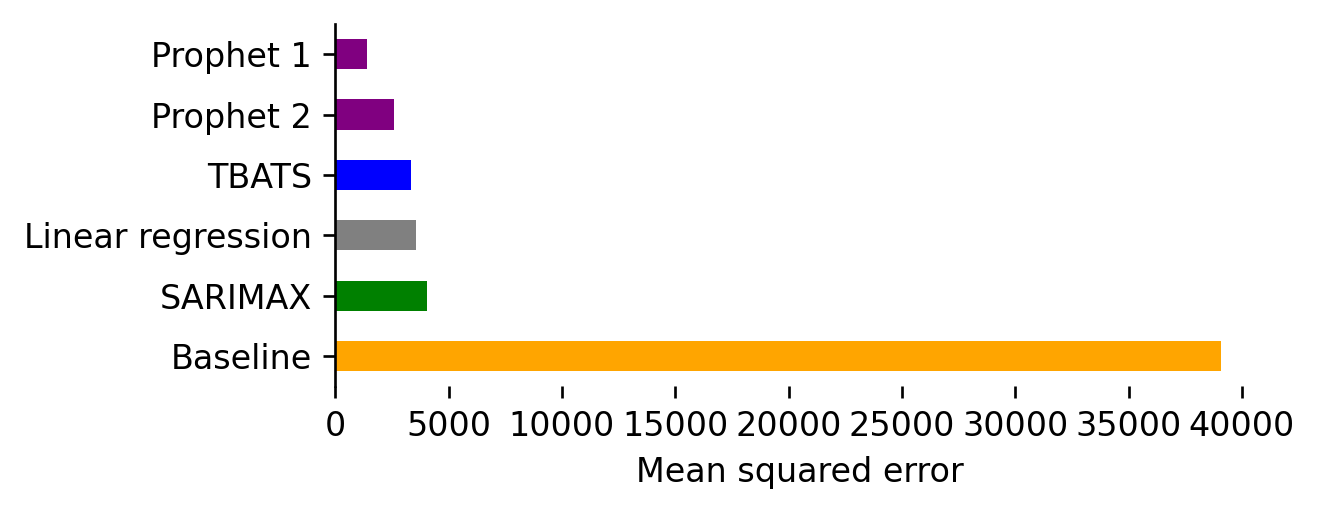

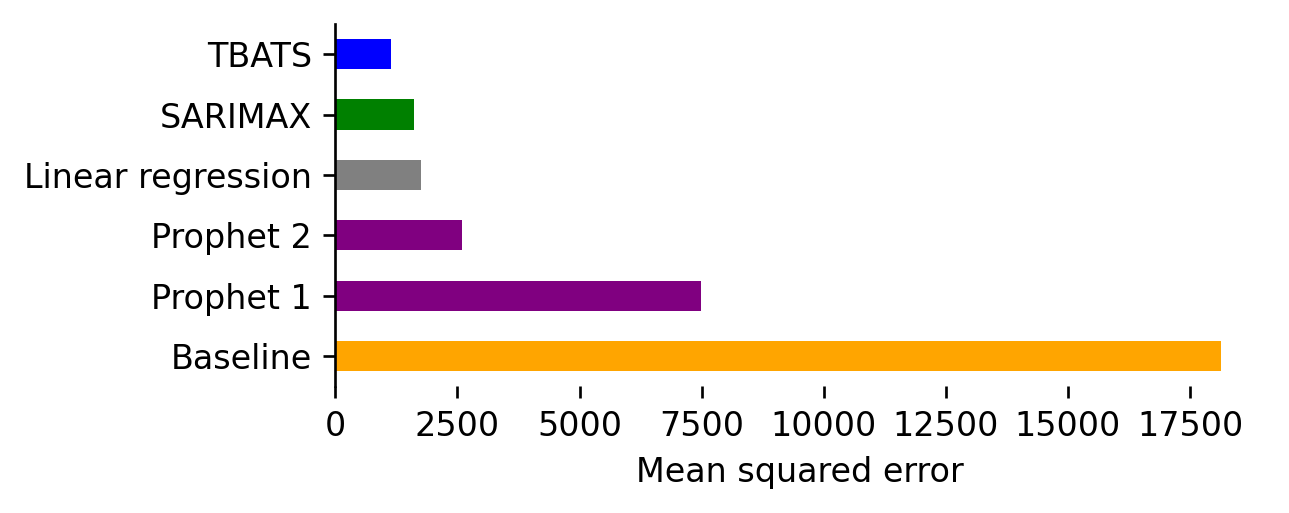

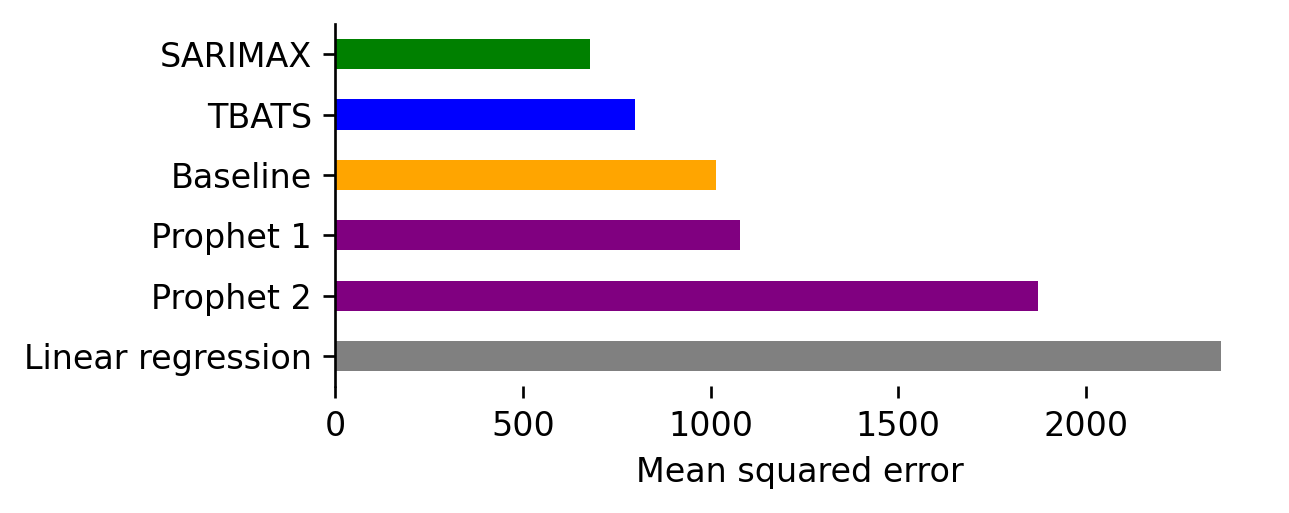

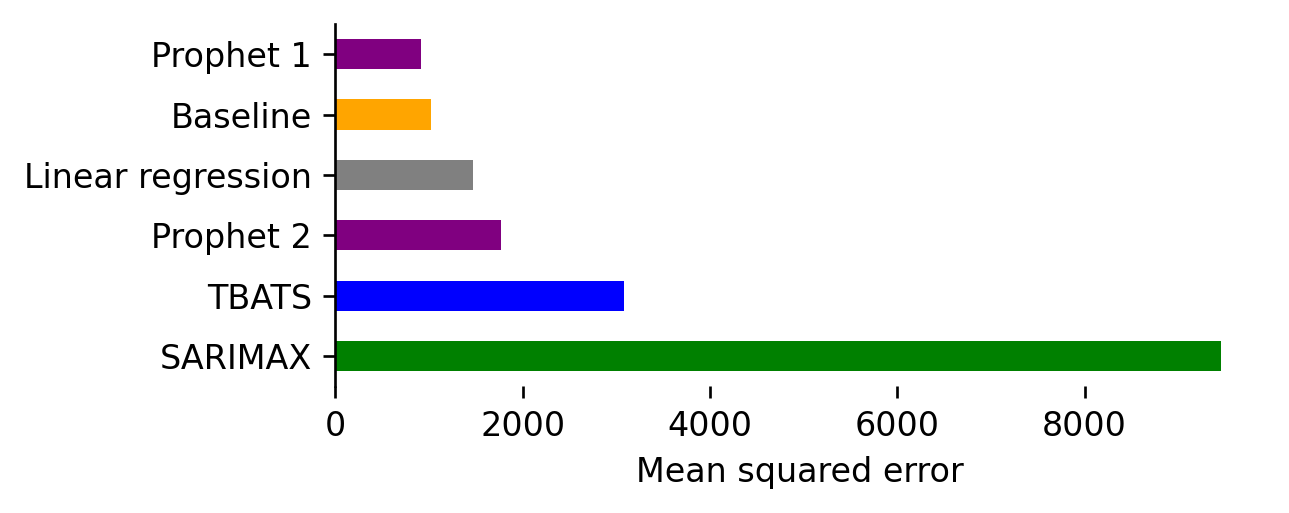

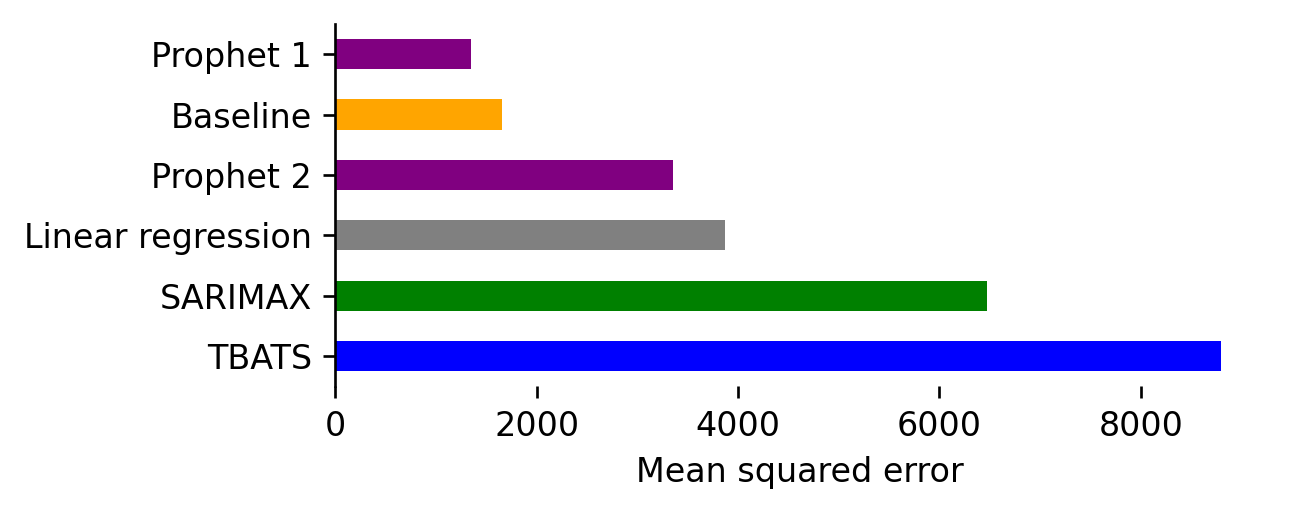

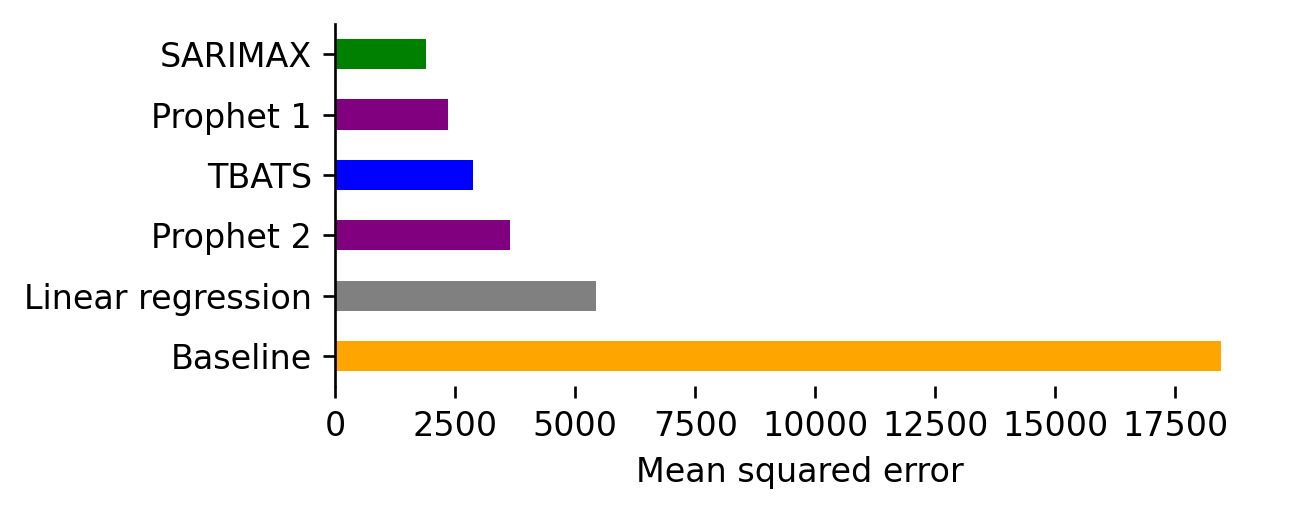

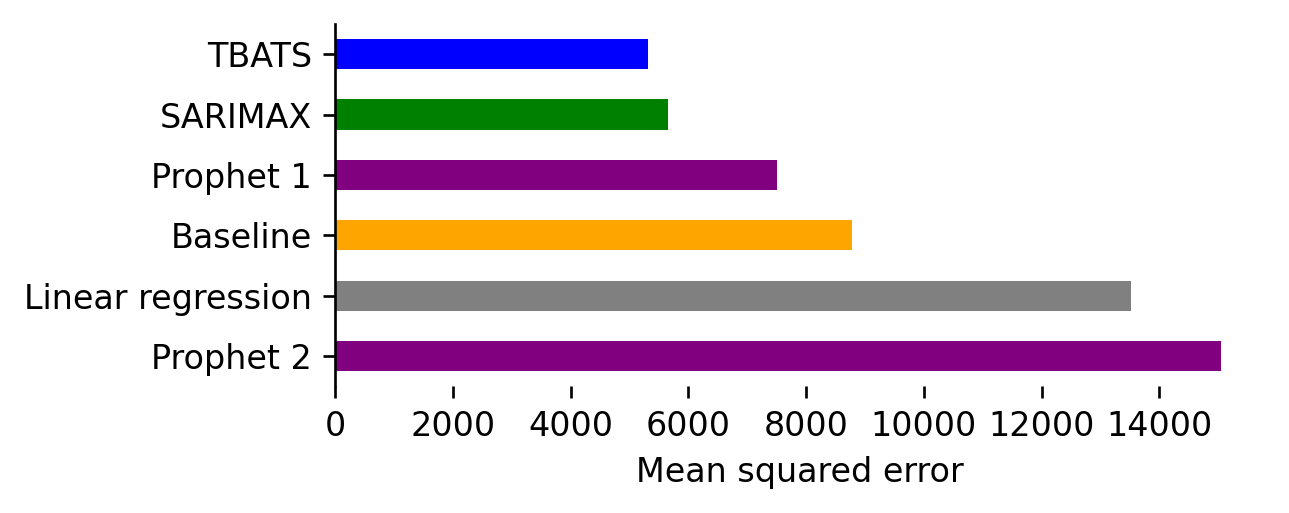

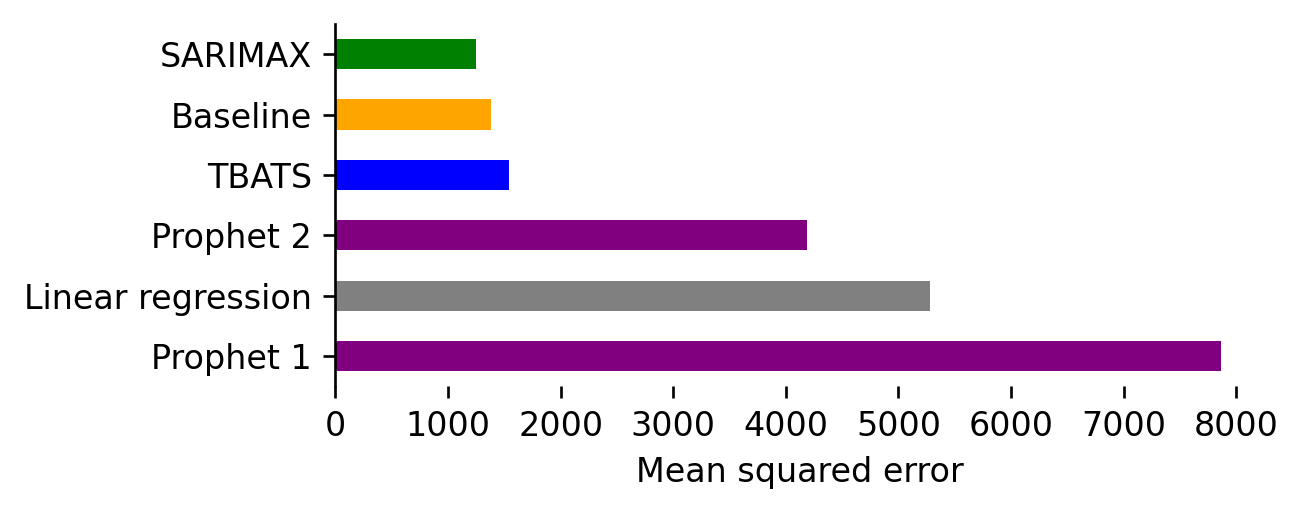

In [10]:
plt.rcParams['figure.figsize'] = [12, 4]

#TODO: take keys from selection dictionary or from actual used names.
#all_performances = {
#    "baseline": [],
#    "linear_regression": [],
#    "TBATS": [],
#    "sarimax": [],
#    "ARIMA": [],
#    "prophet": [],
#}
all_performances = {di['name']: [] for di in selectors}

indices = [32135, 33311, 26478, 33357, 30387, 30794, 31800, 28783]
for index in indices:
    fig, ax = plt.subplots()
    fig.set_figheight(2)
    fig.set_figwidth(5)
    fig.set_dpi(240)

    plot_df = (df[df["index"] == index]
                .sort_values("mse", ascending=False)
                #.assign(col = lambda x:x["model"].map(lambda x: model2color.get(x, "black")))
                #.assign(label = lambda x: f"{x['model']}{steps2str(x['train_steps'])}")
                .drop_duplicates(subset=["run_name"])
    )
    plot_df["rmse"] = np.sqrt(plot_df["mse"])

    
    for idx, benchmark in plot_df.iterrows():
        all_performances[benchmark["name"]].append(benchmark["mse"])
    
    if USE_ROOT:
        score_col = "rmse"
    else:
        score_col = "mse"
    plot_df.plot.barh(x="disp_label", y=score_col, color=plot_df["disp_color"], legend=None, ax=ax)
    #ax.barh(plot_df["mse"], width=20, color=plot_df["col"], legend=None, height=0.9)
    axis_label = "Root Mean Squared Error" if USE_ROOT else "Mean squared error"
    ax.set_xlabel(axis_label)
    ax.set_ylabel(None)
    #fig.suptitle(f"{str(index2datetime(index+1))} to {str(index2datetime(index+24))}")
    fig.suptitle("")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

In [13]:
avg_performance = {}
for k, v in all_performances.items():
    #if k == "ARIMA":
    #    continue
    #print(k, v)
    #avg_performance[k] = [0]
    avg_performance[k] = np.mean(v) #TODO: check if I am overwriting sth here
display(all_performances)
display(avg_performance)
mmses = pd.concat([pd.DataFrame({"model": [k], "mmse": [v]}) for k, v in avg_performance.items()], axis=0)
mmses = mmses.sort_values("mmse", ascending=False)
mmses

{'baseline': [39081.913320875006,
  18135.40969808334,
  1013.4307176249999,
  1023.5640234166668,
  1653.4104304583354,
  18452.863769333326,
  8773.648481083334,
  1380.2287232083336],
 'linear_regression': [3578.475104936782,
  1757.8487409294528,
  2360.0736493497575,
  1471.1906422020636,
  3867.051162197113,
  5421.919952237995,
  13512.425442471655,
  5283.047960421681],
 'tbats': [3318.8593735961317,
  1142.4361789186974,
  797.6009151411023,
  3078.817254167008,
  8797.725451260141,
  2872.4892528083715,
  5320.377756926917,
  1543.459402511964],
 'sarimax': [4024.085812113825,
  1613.8730216736894,
  678.9240996805794,
  9456.443234371023,
  6473.816090296964,
  1880.3140765943347,
  5657.315594917688,
  1251.0392647651126],
 'prophet_1': [1386.816221148235,
  7495.0155561344245,
  1077.6332696415136,
  913.0020305046413,
  1350.8072458025115,
  2340.0446739596946,
  7497.672499975314,
  7864.630255322441],
 'prophet_2': [2581.4853195855558,
  2603.1232170936123,
  1872.79126

{'baseline': 11189.308645510417,
 'linear_regression': 4656.504081843312,
 'tbats': 3358.9706981662916,
 'sarimax': 3879.4763993016522,
 'prophet_1': 3740.7027190610966,
 'prophet_2': 4384.240822947044}

,model,mmse
0,baseline,11189.308646
0,linear_regression,4656.504082
0,prophet_2,4384.240823
0,sarimax,3879.476399
0,prophet_1,3740.702719
0,tbats,3358.970698


In [ ]:

mmses["color"] = mmses.model.map(lambda x: model2color.get(x, "black"))

fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(9)
fig.set_dpi(240)

mmses.plot.barh(x="model", y="mmse", color=mmses["color"], ax=ax)
ax.set_xlabel("Average performance (Mean Squared Error)")
ax.set_ylabel("")
ax.legend().remove()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

In [ ]:
# Load the actual dataset
def get_df(building_nr, feature):
    if building_nr == "all":
        filename = "Agg_buildings.csv"
    else:
        filename = f"Building_{building_nr}.csv"
    df = (
    pd.read_csv(Path("../data/preprocessed") / filename)
        .astype({'datetime': 'datetime64'})
        [[feature, "datetime"]]
        .rename(columns={feature: "actual"})
    )
    df.index.name = "id"
    return df

actual_df = get_df(BUILDING_NR, "net_load_kW")

In [ ]:
plt.rcParams['figure.figsize'] = [25, 6]

index_to_plot = indices[7]
#index_to_plot = indices[1]
plot_df = df[df["index"] == index_to_plot].drop_duplicates(subset=["run_name"])
plot_df

In [ ]:
from pandas import concat


df_from_csv_1 = pd.read_csv("../data/results/linear_regression.csv")
df_from_csv_2 = pd.read_csv("../data/results/sarimax_(2,1,1)(1,0,1,24).csv")
df_from_csv = pd.concat([df_from_csv_1, df_from_csv_2], axis=0, ignore_index=True)[["runid", "id", "prediction"]].rename(columns={"runid": "run_id"})
#df_from_csv.head()

In [ ]:
#def y_fmt(x, y):
#    if max_y > 1000000:
#        val = int(y)/1000000
#        return '{:d} M'.format(val)
#    elif max_y > 1000:
#        val = int(y) / 1000
#        return '{:d} k'.format(val)
#    else:
#        return y
import matplotlib.ticker as tick
from matplotlib.dates import DateFormatter

y_true = actual_df.loc[index_to_plot+1:index_to_plot+24].set_index("datetime")

fig = plt.figure(figsize=(11,3), dpi=240)
ax = fig.add_subplot(111)


for run_id, run_data in plot_df.iterrows():
    plot_kwargs = {}
    query_string = f"SELECT * FROM forecast WHERE run_id='{run_id}'" # LIMIT 10"
    run_predictions = pd.read_sql(query_string, db).drop(columns="run_id")
    if len(run_predictions) == 0:
        #print(f"[INFO: for {run_id}, there is not data in the SQL database.]")
        #print(f"[...trying to read from csv file]")
        run_predictions = df_from_csv[df_from_csv.run_id == run_id].copy().drop(columns="run_id")
        if len(run_predictions) == 0:
            print(f"[Warning: didn't find {run_id} csv data]")
            continue
        if run_data.run_name in ["linear_regression", "sarimax_(2,1,1)(1,0,1,24)"]:
            plot_kwargs = {
                'linestyle': 'dashed'
            }

    run_predictions["datetime"] = run_predictions["id"].map(index2datetime)#y_true.index
    color = model2color.get(run_data.model, "gray")
    ax.plot(run_predictions.drop(columns=["id"]).set_index("datetime"), color=color, label=run_data["disp_label"], **plot_kwargs)
    #ax.plot(run_predictions.drop(columns=["id"]).set_index("datetime"), color=color, label=run_data["disp_label"])
ax.plot(y_true, color="black", label="actual data");
#plt.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
ax.legend(prop={'size': 9})

def y_fmt(x, y):
    return f"{int(x)} kW"
    #return f"x:{x}; y:{y}"
    #return '{:2.2e}'.format(x).replace('e', 'x10^')

#ax.set_ylim(21, 82)
ax.set_ylim(0, 62)
if BUILDING_NR == 'all':
    ax.set_ylim(-50, 500)
ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
date_form = DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(date_form)
#fig.suptitle("Net energy usage forecasts (Year 4, Sep 2)")
fig.suptitle("Net energy usage forecasts (Year 4, Apr 15 - 16)")
ax.legend(bbox_to_anchor=(1,0), loc="lower left")

In [ ]:
query_string = "SELECT * FROM forecast" # LIMIT 10"
run_predictions = pd.read_sql(query_string, db)

In [ ]:
len(run_predictions)

In [ ]:
indices = [32135, 33311, 26478, 33357, 30387, 30794, 31800, 28783]
times = [(index2datetime(i), i+1, i+24) for i in indices]
display(times)

# upload building data from csv to database

In [ ]:
if False:
    building_nr = 5
    df = pd.read_csv(f"../data/preprocessed/Building_{building_nr}.csv").astype({'datetime': 'datetime64'})
    df.index.name = "id"
    
    df.to_sql("building5", con=db)